#### Libraries

In [1]:
import os
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import gmean


#### Function to parse logs

In [2]:
# base_dir - prefix directory for all logs
# traces - trace names for which logs to parse (X axis)
# configs - configuration names (Labels)
# line_parser - callable that uses regex on a log file to extract required values
def parse_logs(base_dir, traces, configs, line_parser):
    parsed_values = {trace: {} for trace in traces}
    for trace in traces:
        for config in configs:
            log_file = base_dir + f"{trace}-{config}.log"
            parsed_values[trace][config] = line_parser(log_file)
    return parsed_values

#### Main plotting function

In [38]:
# data - 
# confignames - labels of configuration
# xticks - Traces names
# xlabel - String denoting X axis label
# ylabel - String denoting Y axis label
# title - String denoting title of graph
# barwidth - optional parameter to control bar spacing
# addbaseline - optional parameter to control whether to add a dashed horizontal line at y = 1
def plot(data, confignames, xticks, xlabel, ylabel, title, barwidth=0.2, addbaseline=True):
    # Plotting the speedups
    plt.rcParams.update({'font.size': 10})
    x = np.arange(len(xticks))  # X axis positions for the traces
    width = barwidth  # Width of the bars

    fig, ax = plt.subplots(figsize=(10, 5))

    # Plot bars for each configuration
    for i, config in enumerate(confignames):
        _values = [data[tick][config] for tick in xticks]
        bars = ax.bar(x + i*width, _values, width, label=config)

        # Annotate bars with speedup values
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',  # Format the annotation to 2 decimal places
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # Offset text slightly above the bar
                        textcoords="offset points",
                        ha='center', va='bottom', rotation=90)

    if(addbaseline):
        # Add a translucent dashed line at y=1.0 for the baseline
        ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)


    # Add labels and titles
    ax.set_xlabel(xlabel)
    ax.set_ylim(0, 5.0)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x + (len(confignames)-1)*width / 2)
    ax.set_xticklabels(xticks, rotation=35)
    ax.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()


#### Utility function to list all filenames with given extension in a directory

In [5]:
def list_trace_names(directory, extension):
    file_names = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(extension):
                file_name_custom = ".".join(file.split(".")[:-2])
                file_names.append(file_name_custom)
    return file_names

### Plotting Speedup

##### Function to calculate speedup and geomean

In [6]:
def calc_speedup(ipc_values, trace_names, configs):
    speedups = {trace: {} for trace in trace_names}
    for trace in trace_names:
        baseline_ipc = ipc_values[trace]['baseline']
        for config in configs:  # Skip baseline
            speedups[trace][config] = ipc_values[trace][config] / baseline_ipc
    # Calculate geometric mean for each configuration (excluding baseline)
    geomeans = {}
    for config in configs:
        config_speedups = [speedups[trace][config] for trace in trace_names]
        geomeans[config] = gmean(config_speedups)  # Use scipy's gmean for geometric mean

    speedups['Geomean'] = geomeans
    return speedups

##### Callable to parse ipc values from a given logfile path

In [7]:
def extract_ipc(log_file):
    with open(log_file, 'r') as f:
        for line in f:
            if 'CPU 0 cumulative IPC' in line:
                ipc_value = float(re.search(r"IPC:\s([\d\.]+)", line).group(1))
                return ipc_value
    return None

#### V1

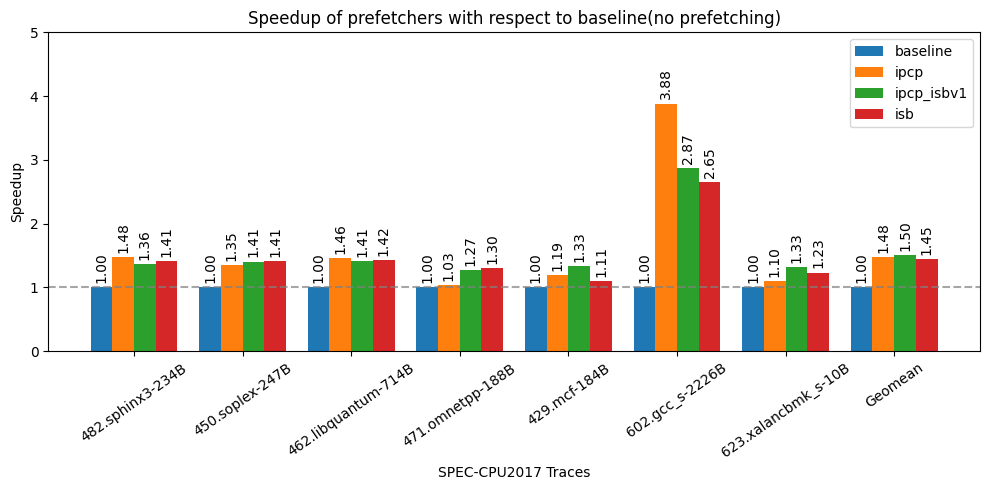

In [42]:
base_dir_v1 = "../logs/SPEC-CPU/v1/"
directory_path = "../traces/SPEC-CPU2017/"
file_extension = ".xz"
configs_v1 = ['baseline', 'ipcp', 'ipcp_isbv1', 'isb']
trace_names_v1  = list_trace_names(directory_path, file_extension)
trace_names_v1.remove('436.cactusADM-1804B') # traces for which logs arent present are removed here
ipc_values_v1 = parse_logs(base_dir_v1, trace_names_v1, configs_v1, extract_ipc)
speedups_v1 = calc_speedup(ipc_values_v1, trace_names_v1, configs_v1)
trace_names_v1 += ["Geomean"]
plot(speedups_v1, configs_v1 ,trace_names_v1, "SPEC-CPU2017 Traces", "Speedup", "Speedup of prefetchers with respect to baseline(no prefetching)")

#### V2

#### Configurations comparison

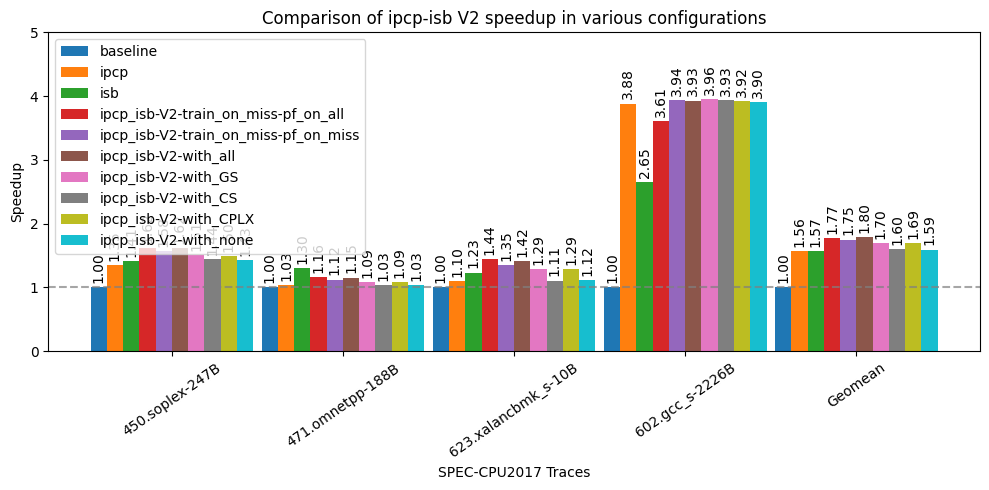

In [43]:
base_dir_v2_comp = "../logs/SPEC-CPU/v2/COMP/"
# Define trace names and configuration labels
trace_names_v2_comp = ['450.soplex-247B', '471.omnetpp-188B', '623.xalancbmk_s-10B', '602.gcc_s-2226B']
configs_v2_comp = ['baseline','ipcp', 'isb' ,'ipcp_isb-V2-train_on_miss-pf_on_all','ipcp_isb-V2-train_on_miss-pf_on_miss' ,'ipcp_isb-V2-with_all', 'ipcp_isb-V2-with_GS', 'ipcp_isb-V2-with_CS', 'ipcp_isb-V2-with_CPLX', 'ipcp_isb-V2-with_none']
ipc_values_v2_comp = parse_logs(base_dir_v2_comp, trace_names_v2_comp, configs_v2_comp, extract_ipc)
speedups_v2_comp = calc_speedup(ipc_values_v2_comp, trace_names_v2_comp, configs_v2_comp)
trace_names_v2_comp += ["Geomean"]
plot(speedups_v2_comp, configs_v2_comp ,trace_names_v2_comp, "SPEC-CPU2017 Traces", "Speedup", "Comparison of ipcp-isb V2 speedup in various configurations", 0.095)

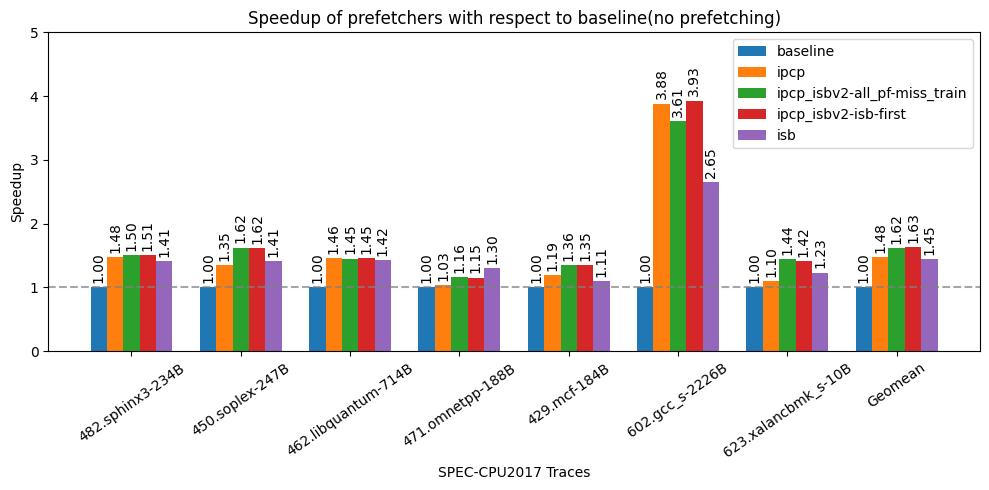

In [45]:
base_dir_v2 = "../logs/SPEC-CPU/v2/"
directory_path = "../traces/SPEC-CPU2017/"
file_extension = ".xz"
configs_v2 = ['baseline', 'ipcp', 'ipcp_isbv2-all_pf-miss_train', 'ipcp_isbv2-isb-first', 'isb']
trace_names_v2  = list_trace_names(directory_path, file_extension)
trace_names_v2.remove('436.cactusADM-1804B') # traces for which logs arent present are removed here
ipc_values_v2 = parse_logs(base_dir_v2, trace_names_v2, configs_v2, extract_ipc)
speedups_v2 = calc_speedup(ipc_values_v2, trace_names_v2, configs_v2)
trace_names_v2 += ["Geomean"]
plot(speedups_v2, configs_v2 ,trace_names_v2, "SPEC-CPU2017 Traces", "Speedup", "Speedup of prefetchers with respect to baseline(no prefetching)", 0.15)

#### V3

In [ ]:
base_dir_v3 = "../logs/SPEC-CPU/v2/"
directory_path = "../traces/SPEC-CPU2017/"
file_extension = ".xz"
trace_names_v3  = list_trace_names(directory_path, file_extension)
configs_v3 = ['baseline', 'ipcp', 'ipcp_isb-V3-train_on_miss-pf_on_all', 'isb']
